In [1]:
import os
from zipfile import ZipFile
from pathlib import Path
import requests

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm_notebook

%matplotlib inline
from matplotlib import pyplot as plt

plt.style.use(["seaborn-darkgrid"])
plt.rcParams["figure.figsize"] = (12, 9)
plt.rcParams["font.family"] = "DejaVu Sans"

from sklearn import metrics
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

RANDOM_STATE = 17

In [2]:
def load_har_dataset(url, extract_path: Path, filename: str, overwrite=False):
    # check if existed already
    filepath = extract_path / filename
    if filepath.exists() and not overwrite:
        print("The dataset is already in place.")
        return

    print("Downloading the dataset from:  ", url)
    response = requests.get(url)

    with open(filepath, 'wb') as f:
        f.write(response.content)

    with ZipFile(filepath, 'r') as zipObj:
        # Extract all the contents of zip file in current directory
        zipObj.extractall(extract_path)

In [4]:
FILE_URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip"
FILE_NAME = "UCI HAR Dataset.zip"
DATA_PATH = Path("data/large_files")

load_har_dataset(url=FILE_URL, extract_path=DATA_PATH, filename=FILE_NAME)

PATH_TO_SAMSUNG_DATA = DATA_PATH / FILE_NAME.strip('.zip')

In [5]:
X_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "X_train.txt")
y_train = np.loadtxt(PATH_TO_SAMSUNG_DATA / "train" / "y_train.txt").astype(int)

X_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "X_test.txt")
y_test = np.loadtxt(PATH_TO_SAMSUNG_DATA / "test" / "y_test.txt").astype(int)

In [6]:
# Checking dimensions
assert X_train.shape == (7352, 561) and y_train.shape == (7352,)
assert X_test.shape == (2947, 561) and y_test.shape == (2947,)

In [11]:
y_train

array([5, 5, 5, ..., 2, 2, 2])

In [12]:
y_test

array([5, 5, 5, ..., 2, 2, 2])

In [14]:
# Your code here
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])

In [15]:
np.unique(y)

array([1, 2, 3, 4, 5, 6])

In [39]:
n_classes = np.unique(y).size

In [40]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [41]:
pca = PCA(n_components=0.9, random_state=RANDOM_STATE).fit(X_scaled)
X_pca = pca.transform(X_scaled)

In [42]:
X_pca.shape

(10299, 65)

In [43]:
round(float(pca.explained_variance_ratio_[0] * 100))

51

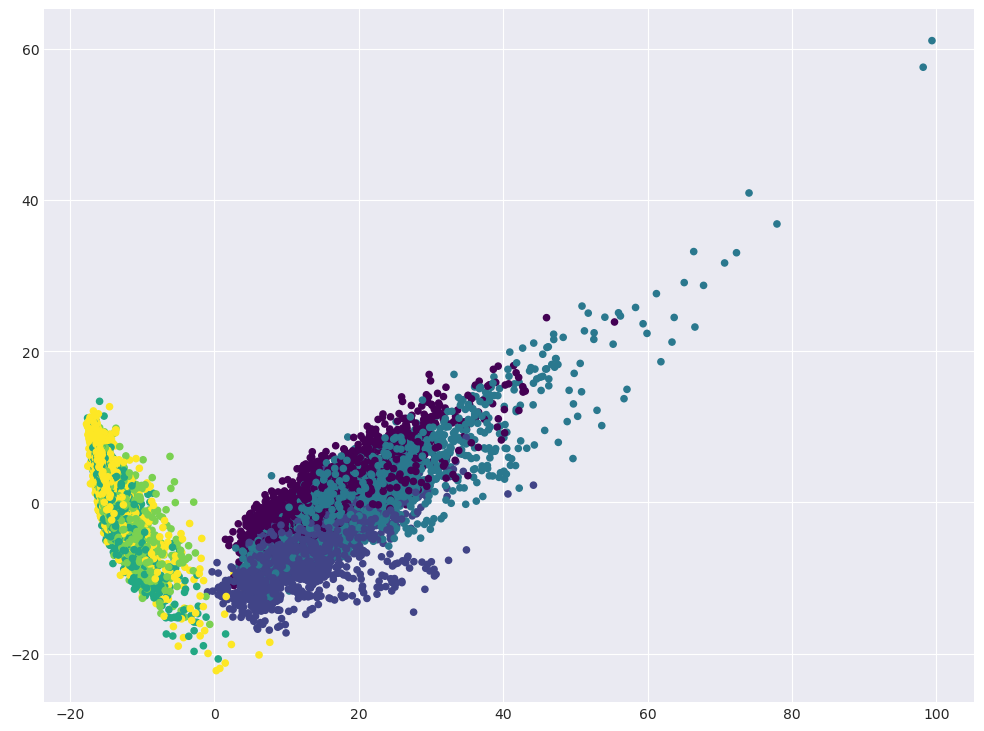

In [44]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap="viridis");

In [45]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, random_state=RANDOM_STATE)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

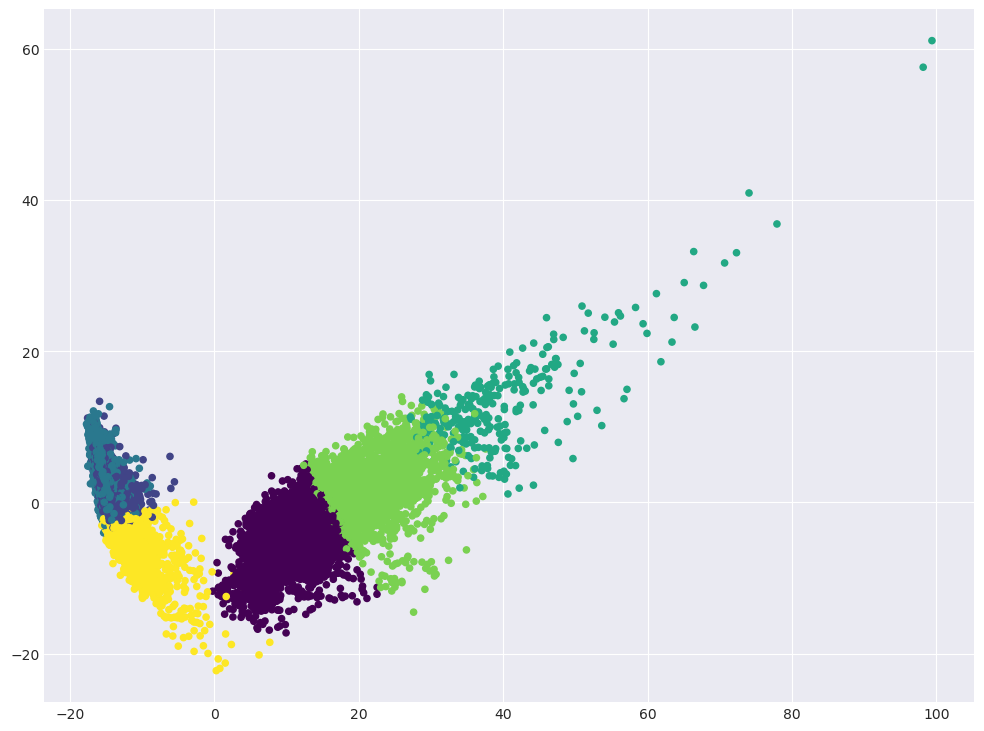

In [46]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20, cmap="viridis");

In [47]:
tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = [
    "walking",
    "going up the stairs",
    "going down the stairs",
    "sitting",
    "standing",
    "laying",
    "all",
]
tab.columns = ["cluster" + str(i + 1) for i in range(6)] + ["all"]
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,0,78,741,0,1722
going up the stairs,1241,0,0,5,296,2,1544
going down the stairs,320,0,0,196,890,0,1406
sitting,1,1235,91,0,0,450,1777
standing,0,1344,0,0,0,562,1906
laying,5,52,1558,0,0,329,1944
all,2470,2631,1649,279,1927,1343,10299


In [48]:
pd.Series(
    tab.iloc[:-1, :-1].max(axis=1).values / tab.iloc[:-1, -1].values,
    index=tab.index[:-1],
)

walking                  0.524390
going up the stairs      0.803756
going down the stairs    0.633001
sitting                  0.694992
standing                 0.705142
laying                   0.801440
dtype: float64

In [49]:
# Your code here
inertia = []
for k in tqdm_notebook(range(1, n_classes + 1)):
    kmeans = KMeans(n_clusters=k, n_init=100, random_state=RANDOM_STATE).fit(
        X_pca
    )
    inertia.append(np.sqrt(kmeans.inertia_))

/var/folders/9t/d2tzjb412n723my412tvgtth0000gn/T/ipykernel_60877/301774213.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for k in tqdm_notebook(range(1, n_classes + 1)):


  0%|          | 0/6 [00:00<?, ?it/s]

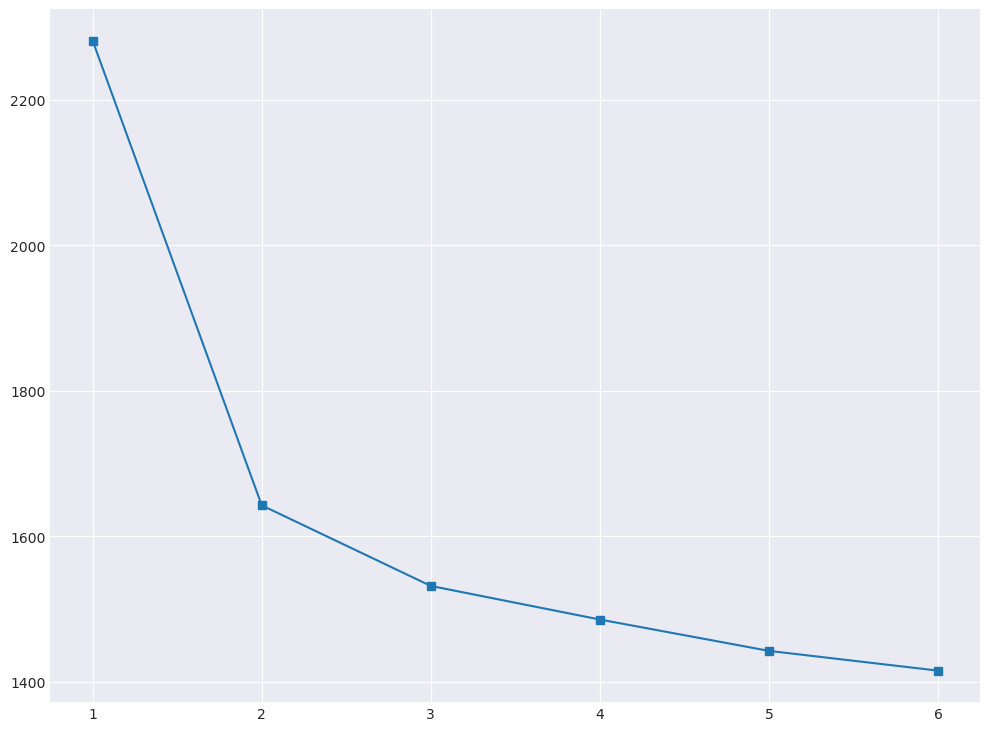

In [50]:
plt.plot(range(1, 7), inertia, marker="s");

In [51]:
d = {}
for k in range(2, 6):
    i = k - 1
    d[k] = (inertia[i] - inertia[i + 1]) / (inertia[i - 1] - inertia[i])

In [52]:
ag = AgglomerativeClustering(n_clusters=n_classes, linkage="ward").fit(X_pca)

In [53]:
# Your code here
print("KMeans: ARI =", metrics.adjusted_rand_score(y, cluster_labels))
print("Agglomerative CLustering: ARI =", metrics.adjusted_rand_score(y, ag.labels_))

KMeans: ARI = 0.4198070012602345
Agglomerative CLustering: ARI = 0.49362763373004886


In [54]:
# Your code here
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [55]:
svc = LinearSVC(random_state=RANDOM_STATE)
svc_params = {"C": [0.001, 0.01, 0.1, 1, 10]}

In [56]:
%%time
# Your code here
best_svc = GridSearchCV(svc, svc_params, n_jobs=4, cv=3, verbose=1)
best_svc.fit(X_train_scaled, y_train);

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/Users/valentinshapovalov/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valentinshapovalov/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valentinshapovalov/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valentinshapovalov/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valentinshapovalov/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/valentin

CPU times: user 3.08 s, sys: 76.3 ms, total: 3.16 s
Wall time: 12.7 s


/Users/valentinshapovalov/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


GridSearchCV(cv=3, estimator=LinearSVC(random_state=17), n_jobs=4,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10]}, verbose=1)